In [1]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from scipy.misc import imread
import numpy as np
import glob
import os
import sys
from skimage import io, color, filters, feature, restoration

In [2]:
import sys
sys.path.append("..")

In [3]:
from src.standardizer import Standardizer
from src.imageData_generator import ImageGenerator

In [4]:
# print('Loading model')
# model_path = 'models/models/CNN_E100_Batch10_Filters64_Neurons64_Actrelu_Layers_3.h5'
# model = load_model(model_path)

# print('Loading resized images')
resized_imgs = glob.glob('data/medium/*')



/Users/reiffd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


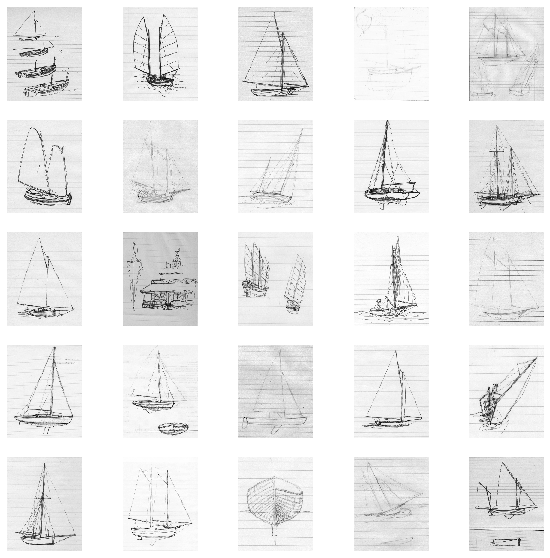

In [5]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i, a in enumerate(ax.flatten()):
    a.set_axis_off()
    a.imshow(imread(resized_imgs[i], mode='L'), cmap='gray')

/Users/reiffd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


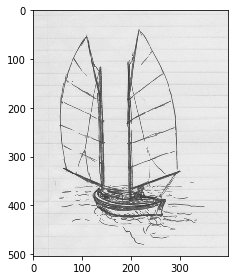

In [12]:
io.imshow(imread(resized_imgs[1]))

In [34]:
arr = imread(resized_imgs[1], mode='L')

/Users/reiffd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [35]:
arr.shape

(504, 400)

In [40]:
first10_flat = arr[:10, :].flatten()

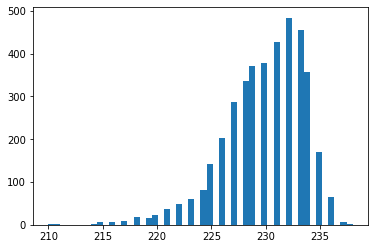

In [41]:
n, bins, patches = plt.hist(first10_flat, bins=50)

In [42]:
bin_max = np.where(n == n.max())

In [44]:
whitespace = bins[bin_max][0]
whitespace

231.84

In [45]:
standardizer = Standardizer(resized_imgs[1])

In [46]:
gray_image = standardizer.greyscale_image
bin_image = standardizer.binarized_image

In [47]:
generator = ImageGenerator(bin_image, gray_image, "aldsk")
generator.pad(15, whitespace)

In [48]:
gray = generator.gray_padded_image
binar = generator.bin_padded_image

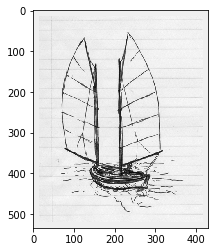

In [49]:
plt.imshow(gray, cmap='gray')

In [6]:
print('Subset the images that we want, the ones we trained the model on')
img_list = [164, 202, 425, 345, 139, 72, 311, 363, 403, 509, 362, 257, 175, 203, 47, 183, 0, 297, 34, 8, 320, 197, 293, 450, 215, 28, 74]
img_subset = []
for img in resized_imgs:
    img_idx = int(img.split('/')[2].split('_')[0])
    if img_idx in img_list:
        img_subset.append(img)

print('Standardize the images')
standardizer_subset = Standardizer(img_subset, resized_imgs[3])

print('Select the image we want to scrub')
bin_image = standardizer_subset.binarized_images[20]
grey_image = standardizer_subset.greyscale_image_list[20]
img_name = standardizer_subset.image_list[20].split('/')[2].split('.')[0]
print(img_name)

Subset the images that we want, the ones we trained the model on
Standardize the images
Select the image we want to scrub


IndexError: index 20 is out of bounds for axis 0 with size 0

In [13]:
images = ImageGenerator(bin_image, grey_image, img_name)
images.pad(15, 200)
gray = images.gray_padded_image
binar = images.bin_padded_image

In [28]:
def plot_frame(zoom, row_index, col_index, size, prediction):
    masked_window = np.random.random((zoom.shape[0],zoom.shape[1]))
    masked_window[row_index:row_index+size, col_index:col_index+size] = 1
    masked_window = np.ma.masked_where(masked_window != 1, masked_window)

    masked_pixel = np.random.random((zoom[row_index:row_index+size, col_index:col_index+size].shape[0],zoom[row_index:row_index+size, col_index:col_index+size].shape[1]))
    masked_pixel[15,15] = 1
    masked_pixel = np.ma.masked_where(masked_pixel != 1, masked_pixel)

    masked_pixel1 = np.random.random((zoom[row_index:row_index+size, col_index:col_index+size].shape[0],zoom[row_index:row_index+size, col_index:col_index+size].shape[1]))
    masked_pixel1[8:23, 15] = 1
    masked_pixel1 = np.ma.masked_where(masked_pixel1 != 1, masked_pixel1)
    
    window = zoom[row_index:row_index+size, col_index:col_index+size]
    colored_percentage = np.count_nonzero(window==0)/(30**2)
    pixel_value = window[15, 15]
    window_sobel = ndimage.sobel(window, axis=0)
    above_area = np.mean(window_sobel[8:16, 15])
    below_area = np.mean(window_sobel[16:23, 15])
    sobel_value = window_sobel[15, 15]
    
    if prediction > 0.55:
        label = 'Line'
    else:
        label = 'Drawing'
    # Overlay the two images
    fig, ax = plt.subplots(1, 2)
    ax.ravel()
    ax[0].imshow(zoom, cmap='gray')
    ax[0].imshow(masked_window, cmap='prism', interpolation='none')
    # ax[0].imshow(masked_pixel, cmap=cm.jet, interpolation='none')
    ax[1].imshow(window, cmap='gray')
    ax[1].imshow(masked_pixel, cmap='prism', interpolation='none')
    ax[1].set_title(label, fontsize=20)
    fig.savefig('results/gifs/{}_{}.png'.format(row_index, col_index))
   
    
#     return above_area, below_area, colored_percentage

In [63]:
def plot_featurized(zoom, row_index, col_index, size):
    masked_window = np.random.random((zoom.shape[0],zoom.shape[1]))
    masked_window[row_index:row_index+size, col_index:col_index+size] = 1
    masked_window = np.ma.masked_where(masked_window != 1, masked_window)

    masked_pixel = np.random.random((zoom[row_index:row_index+size, col_index:col_index+size].shape[0],zoom[row_index:row_index+size, col_index:col_index+size].shape[1]))
    masked_pixel[15,15] = 1
    masked_pixel = np.ma.masked_where(masked_pixel != 1, masked_pixel)

    masked_pixel1 = np.random.random((zoom[row_index:row_index+size, col_index:col_index+size].shape[0],zoom[row_index:row_index+size, col_index:col_index+size].shape[1]))
    masked_pixel1[8:23, 15] = 1
    masked_pixel1 = np.ma.masked_where(masked_pixel1 != 1, masked_pixel1)
    
    window = zoom[row_index:row_index+size, col_index:col_index+size]
    mean_pixel = np.mean(window)
    pixel_value = window[15, 15]
    window_sobel = ndimage.sobel(window, axis=0)
    above_area = np.mean(window_sobel[8:16, 15])
    below_area = np.mean(window_sobel[16:23, 15])
    sobel_value = window_sobel[15, 15]
    sobel_gradient = above_area - -below_area
    
    # Overlay the two images
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax.ravel()
    mu = 'Line'
    median = 'Line'
    sigma = 'Line'
    last3 = 'Label -1 = Drawing\n Label -2 = Drawing\n Label -3 = Drawing'
    pixels = 'Mean Pixel Value = {}\n Central Pixel Value = {}'.format(round(mean_pixel), pixel_value)
    sobel = 'Sobel Gradient = {}'.format(round(sobel_gradient, 2))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[0].imshow(zoom, cmap='gray')
    ax[0].imshow(masked_window, cmap='prism', interpolation='none')
    ax[0].text(0.6, 0.95, last3, transform=ax[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    ax[1].imshow(window, cmap='gray')
    ax[1].imshow(masked_pixel, cmap='prism', interpolation='none')
    ax[1].text(0.4, 0.95, pixels, transform=ax[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    ax[2].imshow(window_sobel)
    ax[2].imshow(masked_pixel1, cmap='jet')
    ax[2].imshow(masked_pixel, cmap='prism', interpolation='none')
    ax[2].text(0.4, 0.95, sobel, transform=ax[2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    
   

In [38]:
def demo_gif(row):
    for i in range(400):
        window = gray[row: row+30, i: i+30]
        X = window.reshape(-1, 30, 30, 1)
        prediction = model.predict(X)[0][0]
        plot_frame(gray, row, i, 30, prediction)
        plt.show()


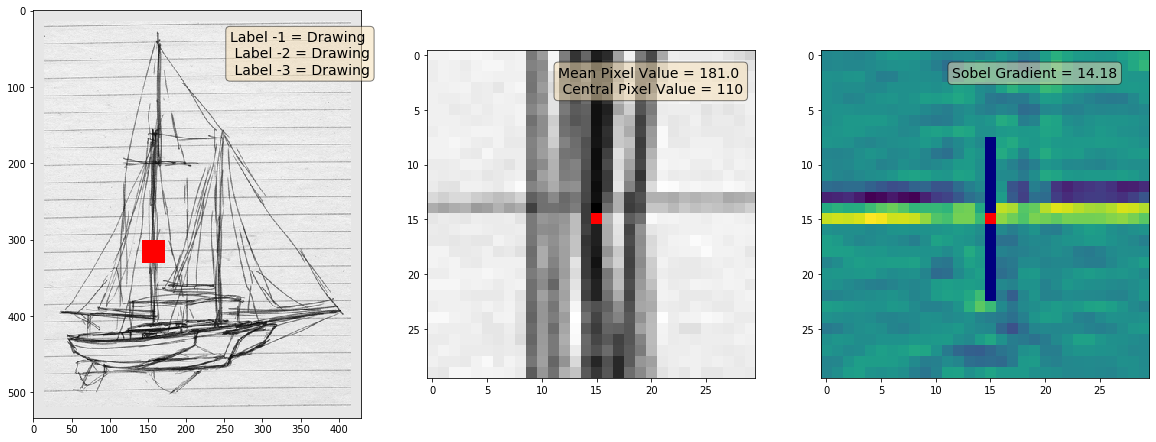

In [64]:
plot_featurized(gray, 301, 142, 30)



1.0